# Web Data Scraping

[Spring 2019 ITSS Mini-Course](https://www.colorado.edu/cartss/programs/interdisciplinary-training-social-sciences-itss/mini-course-web-data-scraping) — ARSC 5040  
[Brian C. Keegan, Ph.D.](http://brianckeegan.com/)  
[Assistant Professor, Department of Information Science](https://www.colorado.edu/cmci/people/information-science/brian-c-keegan)  
University of Colorado Boulder  

Copyright and distributed under an [MIT License](https://opensource.org/licenses/MIT)

## Class outline

I've flipped weeks 3 and 4!

* **Week 1**: Introduction to Jupyter, browser console, structured data, ethical considerations
* **Week 2**: Scraping HTML with `requests` and `BeautifulSoup`
* **Week 4**: Scraping web data with Selenium, other tools for automated scraping
* **Week 3**: Scraping an API with `requests` and `json`, Wikipedia
* **Week 5**: Authenticating through an API, Twitter & Reddit

## Acknowledgements

This course will draw on resources built by myself and [Allison Morgan](https://allisonmorgan.github.io/) for the [2018 Summer Institute for Computational Social Science](https://github.com/allisonmorgan/sicss_boulder), which were in turn derived from [other resources](https://github.com/simonmunzert/web-scraping-with-r-extended-edition) developed by [Simon Munzert](http://simonmunzert.github.io/) and [Chris Bail](http://www.chrisbail.net/). 

Thank you also to Professors [Bhuvana Narasimhan](https://www.colorado.edu/linguistics/bhuvana-narasimhan) and [Stefanie Mollborn](https://behavioralscience.colorado.edu/person/stefanie-mollborn) for coordinating the ITSS seminars.

This notebook is adapted from excellent notebooks in Dr. [Cody Buntain](http://cody.bunta.in/)'s seminar on [Social Media and Crisis Informatics](http://cody.bunta.in/teaching/2018_winter_umd_inst728e/) as well as the [PRAW documentation](https://praw.readthedocs.io/en/latest/).

## Class 3 goals

* Sharing accomplishments and challenges with last week's material
* Why you don't want to write a parser for Wikipedia's data
* Accessing an API with `requests`
* Fundamentals of retrieving information from Wikipedia's API
* EDA with data from Wikipedia's API
* Reddit's API, time permitting

We'll need a few common libraries for all these examples.

In [251]:
# Lets us talk to other servers on the web
import requests

# APIs spit out data in JSON
import json

# Use BeautifulSoup to parse some HTML
from bs4 import BeautifulSoup

# Handling dates and times
from datetime import datetime

# DataFrames!
import pandas as pd

# Data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

## Scraping Wikipedia

Consider the Wikipedia page for [George H.W. Bush](https://en.wikipedia.org/wiki/George_H._W._Bush). This seems like a relatively straightforward webpage to scrape out the hyperlinks to other articles or to compare the content to other presidential biographies. However, Wikipedia also preserves the [history of every revision made to this article](https://en.wikipedia.org/w/index.php?title=George_H._W._Bush&action=history) going back to the first (available) revisions in 2001, like [this](https://en.wikipedia.org/w/index.php?title=George_H._W._Bush&oldid=345784898). Thinking back to the Oscars example, it seems promising to find the "oldid" values and visit each revision's webpage to parse the content out. However, Wikipedia will give you much of this revision history data for free through its [application programming interface](http://en.wikipedia.org/w/api.php) (API).

### Current content
We can use `requests` to get the current HTML markup of an article from the API, for example.

In [245]:
# Where the API server lives
query_url = "https://en.wikipedia.org/w/api.php"

# An empty dictionary to store our query parameters
query_params = {}

# We want to parse the content of a page
query_params['action'] = 'parse'

# Which page?
query_params['page'] = 'George H. W. Bush'

# We want the text
query_params['prop'] = 'text'

# Ignore the edit buttons and table of contents
query_params['disableeditsection'] = 1
query_params['disabletoc'] = 1

# Get the results back as JSON
query_params['format'] = 'json'

# Format the data in an easier-to-parse option
query_params['formatversion'] = 2

We have only set up our request to the API, but not sent it or received the data back.

In [246]:
json_response = requests.get(url = query_url, params = query_params).json()

What's waiting inside? A dictionary of dictionaries. The inner dictionary has keys for the title of the page we requested ("George H. W. Bush"), the pageid (a numeric identifier), and the text of the article.

In [250]:
json_response['parse'].keys()

dict_keys(['title', 'pageid', 'text'])

We could count the number of links in the article.

In [256]:
ghwb_soup = BeautifulSoup(json_response['parse']['text'])

ghwb_soup.find_all('a')[:5]

[<a href="/wiki/George_W._Bush" title="George W. Bush">George W. Bush</a>,
 <a class="mw-redirect mw-disambig" href="/wiki/George_Bush_(disambiguation)" title="George Bush (disambiguation)">George Bush (disambiguation)</a>,
 <a class="image" href="/wiki/File:George_H._W._Bush_crop.jpg"><img alt="George H. W. Bush crop.jpg" data-file-height="1850" data-file-width="1471" decoding="async" height="277" src="//upload.wikimedia.org/wikipedia/commons/thumb/e/ee/George_H._W._Bush_crop.jpg/220px-George_H._W._Bush_crop.jpg" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/e/ee/George_H._W._Bush_crop.jpg/330px-George_H._W._Bush_crop.jpg 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/e/ee/George_H._W._Bush_crop.jpg/440px-George_H._W._Bush_crop.jpg 2x" width="220"/></a>,
 <a href="/wiki/President_of_the_United_States" title="President of the United States">President of the United States</a>,
 <a href="/wiki/Vice_President_of_the_United_States" title="Vice President of the United States"

Or the content of the article.

In [255]:
ghwb_soup.find_all('p')[:5]

[<p class="mw-empty-elt">
 </p>,
 <p><b>George Herbert Walker Bush</b> (June 12, 1924 – November 30, 2018) was an American politician who served as the 41st <a href="/wiki/President_of_the_United_States" title="President of the United States">president of the United States</a> from 1989 to 1993. Prior to assuming the presidency, Bush served as the 43rd <a class="mw-redirect" href="/wiki/Vice_president_of_the_United_States" title="Vice president of the United States">vice president of the United States</a> from 1981 to 1989. A member of the <a href="/wiki/Republican_Party_(United_States)" title="Republican Party (United States)">Republican Party</a>, his earlier posts included those of congressman, ambassador, and <a href="/wiki/Director_of_Central_Intelligence" title="Director of Central Intelligence">CIA director</a>. During his career in public service, he was known simply as <b>George Bush</b>, but after his son <a href="/wiki/George_W._Bush" title="George W. Bush">George W. Bush</a

### Revision history

There is also an API endpoint for the revision history of this article that contains metadata about the who and when of previous changes.

In [260]:
# Where the API server lives
query_url = "https://en.wikipedia.org/w/api.php"

# An empty dictionary to store our query parameters
query_params = {}

# We want to query properties of a page
query_params['action'] = 'query'

# Which page?
query_params['titles'] = 'George H. W. Bush'

# We want the revisions
query_params['prop'] = 'revisions'

# In particular, we want the revision ids, users, comments, timestamps
query_params['rvprop'] = 'ids|userid|comment|timestamp|user|size|sha1'

# Get 500 revisions
query_params['rvlimit'] = 500

# Start old and go newer
query_params['rvdir'] = 'newer'
    
# Get the results back as JSON
query_params['format'] = 'json'

# Format the data in an easier-to-parse option
query_params['formatversion'] = 2

Make the request.

In [261]:
json_response = requests.get(url = query_url, params = query_params).json()

Inspect this `json_response`. This returns a dictionary with both "continue" and "query" keys. The continue indicates there are more than 500 revisions present in the article's history and provides an index for the next query to pick up from. The query contains the revision history we care about—buried a bit in a nested data structure of lists and dictionaries, but we eventually get to the "revisions" list of dictionaries with the revision histories.

In [269]:
revisions = json_response['query']['pages'][0]['revisions']
revisions[:3]

[{'revid': 345784898,
  'parentid': 345784804,
  'user': 'The Cunctator',
  'userid': 31,
  'timestamp': '2001-09-21T03:12:13Z',
  'size': 1178,
  'sha1': '90f6ea9b117d52570564135c6bfb187f6b9e1674',
  'comment': '*'},
 {'revid': 253862,
  'parentid': 345784898,
  'user': '193.133.134.xxx',
  'anon': True,
  'userid': 0,
  'timestamp': '2001-12-04T16:39:07Z',
  'size': 1249,
  'sha1': '9d3c5c452f5d2039f64627aff0f8fdb60be57845',
  'comment': '*'},
 {'revid': 253863,
  'parentid': 253862,
  'user': '208.144.114.xxx',
  'anon': True,
  'userid': 0,
  'timestamp': '2001-12-08T23:00:26Z',
  'size': 1847,
  'sha1': '1e364b9a487ff421a4a11c19689868e1d71c642e',
  'comment': '*'}]

Convert to a DataFrame.

In [271]:
rev_df = pd.DataFrame(revisions)
rev_df.head()

,anon,comment,parentid,revid,sha1,size,timestamp,user,userid
0,NaN,*,345784804,345784898,90f6ea9b117d52570564135c6bfb187f6b9e1674,1178,2001-09-21T03:12:13Z,The Cunctator,31
1,True,*,345784898,253862,9d3c5c452f5d2039f64627aff0f8fdb60be57845,1249,2001-12-04T16:39:07Z,193.133.134.xxx,0
2,True,*,253862,253863,1e364b9a487ff421a4a11c19689868e1d71c642e,1847,2001-12-08T23:00:26Z,208.144.114.xxx,0
3,True,Automated conversion,253863,17459,76d6afd1a80a1b122ffa8fa23f96f883cb230099,1823,2002-02-24T15:43:20Z,Conversion script,0
4,NaN,Links to elections,17459,42995,dcbb5c79c99b2690d292693dbb53dd1751a21565,1987,2002-02-25T15:51:15Z,RobLa,96


Plot out how the size of the article changed over the first 500 revisions.

(0, 500)

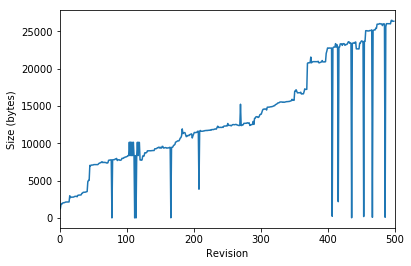

In [276]:
ax = rev_df.plot(y='size',legend=False)
ax.set_ylabel('Size (bytes)')
ax.set_xlabel('Revision')
ax.set_xlim((0,500))

Or count how many times an editor made a contribution.

In [274]:
rev_df['user'].value_counts().head()

Jiang             22
Vzbs34            15
Daniel Quinlan    14
Minesweeper       10
Lst27              8
Name: user, dtype: int64

There are many other parts of the very powerful Wikipedia API and scraping these APIs exposes much more metadata than parsing the HTML of these webpages, while also being easier on the servers hosting it. I will share a notebook that has functions for retrieving and parsing content, revisions, pageviews, and other information.

## Scraping Reddit

Reddit also hosts a lot of detailed behavioral data that could be of interest to social scientists. As was the case with Wikipedia, our naïve inclination may be to develop scrapers and parsers to extract this information, but Reddit will give much of it to you for free through their API!

You can retrieve a few different types of entities from Reddit's API: sub-reddits, submissions, comments, and redditors. Many of these are interoperable: a sub-reddit contains submissions contributed by redditors with comments from other redditors.

We will use a wrapper library to communicate with the Reddit API called [Python Reddit API Wrapper](https://praw.readthedocs.io/en/latest/) or `praw`. 

Copy the code below to your terminal to install `praw`.

conda install -c conda-forge praw 

Afterwards, we can import `praw`.

In [1]:
import praw

We then need to authenticate with Reddit to get access to the API. Typically you can just enter the client ID, client secret, password, username, *etc*. as strings. 

1. You will need to create an account on Reddit. After you have created an account and logged in, go to https://www.reddit.com/prefs/apps/. 
2. Scroll down and click the "create app" button at the bottom. Provide a basic name, description, and enter a URL for your homepage (or just use http://www.colorado.edu).
3. You will need the client ID (the string of characters beneath the name of your app) as well as the secret (the other string of characters) as well as your username and password.
4. You can make up a user-agent string, but include your username as good practice for the sysadmins to track you down if you break things.

![Image from Cody Buntain](http://www.cs.umd.edu/~cbuntain/inst728e/reddit_screens/1-003a.png)

You'll create an API connector object (`r`) below that will authenticate with the API and handle making the requests.

In [ ]:
r = praw.Reddit(client_id='your application id',
                client_secret='your application secret',
                password='your account password',
                user_agent='scraping script by /u/youraccountname',
                username='your account name')

You can confirm that this authentication process worked by making a simple request like printing your username.

In [ ]:
print(r.user.me())

I'm going to read them in from a local file ("login.json") so that I post this notebook on the internet in the future without compromising my account security. This won't work for you, so just skip this step.

In [277]:
# Load my credentials from a local disk so I don't show the world
with open('reddit_login.json','r') as f:
    r_creds = json.load(f)

# Create an authenticated reddit instance using the creds
r = praw.Reddit(client_id = r_creds['client_id'],
                client_secret = r_creds['client_secret'],
                password = r_creds['password'],
                user_agent = r_creds['user_agent'],
                username = r_creds['username'])

# Make sure your reddit instance works
print(r.user.me())

cuinfoscience


### Sub-reddits
Now print the top 25 stories in /r/news.

[Documentation for the Subreddit model in PRAW](https://praw.readthedocs.io/en/latest/code_overview/models/subreddit.html).

Create a `news_subreddit` object to store the various attributes about this sub-reddit.

In [228]:
news_subreddit = r.subreddit('news')

The `news_subreddit` has a number of attributes and methods you can call on it. The time the sub-reddit was founded.

In [70]:
news_subreddit.created_utc

1201243765.0

That's formatted in a UNIX timecode (seconds since 1 January 1970), but we can convert it into a more readable timestamp with `datetime`'s `utcfromtimestamp`.

In [71]:
print(datetime.utcfromtimestamp(news_subreddit.created_utc))

2008-01-25 06:49:25


There are other attributes such as the number of subscribers, current active users, as well as the description of the sub-reddit.

In [223]:
'{0:,}'.format(news_subreddit.subscribers)

'17,532,514'

In [224]:
news_subreddit.over18

False

In [73]:
news_subreddit.active_user_count

22903

In [74]:
print(news_subreddit.description)

>* **[/r/inthenews](/r/inthenews?hl)**

>#

>* **[/r/worldnews](/r/worldnews?hl)**

>#

>* **[/r/politics](/r/politics?hl)**

>#

>* **[new comments](/r/news/comments?hl)**

1. **[Post all analysis/opinion/politics articles to /r/InTheNews](/r/InTheNews)**

> [](http://goo.gl/R6as4?ri)

> [](http://goo.gl/gBldE?ri)

> [](http://goo.gl/u5EZN?ri)

> [](http://goo.gl/exK8j?ri)

> [](http://www.reddit.com/r/news?ri)

> [](http://www.reddit.com/r/restorethefourth?ri)

Want to talk?
                
Follow [@rslashnews on Twitter](https://twitter.com/rslashnews)                    

See a post that violates the rules below? Had your post stuck in the spam filter? Have a question about policy? Just want to give feedback? [Send the mod team a message](http://www.reddit.com/message/compose?to=%2Fr%2Fnews).

---

Submit all self- & meta-posts to /r/inthenews

Your post will likely be removed if it: 

- is not news
- is an opinion/analysis or advocacy piece.
- primarily concerns politics.
- has a

The rules of the sub-reddit are available as a method `.rules()` which returns a list of dictionaries of rule objects.

In [75]:
news_subreddit.rules()['rules']

[{'kind': 'link',
  'description': 'A story that is over a week old, does not properly report a story, or is not noteworthy. Self posts and meta posts without moderator approval (live update threads, major breaking news, and megathreads are usually exempt) should go to /r/InTheNews.',
  'short_name': 'Not news',
  'violation_reason': 'Not news',
  'created_utc': 1453789451.0,
  'priority': 0,
  'description_html': '<!-- SC_OFF --><div class="md"><p>A story that is over a week old, does not properly report a story, or is not noteworthy. Self posts and meta posts without moderator approval (live update threads, major breaking news, and megathreads are usually exempt) should go to <a href="/r/InTheNews">/r/InTheNews</a>.</p>\n</div><!-- SC_ON -->'},
 {'kind': 'link',
  'description': 'Opinion and analysis should go in /r/InTheNews or another relevant subreddit. This includes articles with editorial opinion, personal conjecture, or otherwise. Press releases with an editorial slant, and ana

When were each of these rules created? Loop through each of the rules and print the "short_name" of the rule and the rule timestamp.

In [76]:
for rule in news_subreddit.rules()['rules']:
    created = rule['created_utc']
    print(rule['short_name'], datetime.utcfromtimestamp(created))

Not news 2016-01-26 06:24:11
Opinion/analysis or advocacy piece 2016-01-26 06:27:59
Politics 2016-01-26 06:31:33
Title not from article/editorialized title 2016-01-26 06:35:51
Paywall or is blogspam/steals content 2016-01-26 06:40:33
Covers an already-submitted story 2016-01-26 06:44:40
Racist, sexist, vitriolic, or overly crude 2016-01-26 06:47:09
Unnecessarily rude or provocative 2016-01-26 06:49:35
Cheap or distracting joke or meme 2016-01-26 06:51:12
Breaks sitewide rules, witchhunting 2016-01-26 06:56:47


We can also get a list of the moderators for this subreddit.

In [233]:
mod_list = []

for mod in news_subreddit.moderator():
    mod_list.append(mod.name)
    
mod_list

['douglasmacarthur',
 'Kylde',
 'CandyManCan',
 'Elderthedog',
 'LuckyBdx4',
 'ani625',
 'pomosexuality',
 'luster',
 'RNews_Mod',
 'hoosakiwi',
 'DiggDejected',
 'todayilearned83',
 'gutpocketsucks',
 'ReganDryke',
 'pussgurka',
 'lanismycousin',
 'AudibleNod',
 'adagiosummoner',
 'Bestialman',
 'Kishara',
 'Plainchant',
 'PotRoastPotato',
 'lolihull',
 'topCyder']

### Submissions

We can get a list of submissions to a sub-reddit using [a few different methods](https://praw.readthedocs.io/en/latest/code_overview/models/subreddit.html).

* `.controversial()`
* `.hot()`
* `.new()`
* `.rising()`
* `.search()`
* `.top()`

Here we will use the `.top()` method to get the top 25 submissions on the /r/news subreddit from the past 12 months.

[Documentation for the Submission model in PRAW](https://praw.readthedocs.io/en/latest/code_overview/models/submission.html).

In [ ]:
top25_news = r.subreddit('news').top('year',limit=25)

`top25_news` is a `ListingGenerator` object, which is a special [generator](https://www.dataquest.io/blog/python-generators-tutorial/) class defined by PRAW. It does not actually go out and get the data at this stage. There's not much you can do to look inside this `ListingGenerator` other than loop through and perform operations. In this case, lets add each submission to a list of `top25_submissions`.

In [88]:
top25_submissions = []

for submission in r.subreddit('news').top('year',limit=25):
    top25_submissions.append(submission)

We can inspect the first (top) `Submission` object.

In [225]:
first_submission = top25_submissions[0]
first_submission

Submission(id='84aebi')

Use the `dir` function to see the other methods and attributes inside this first top `Submission` object. (There are a lot of other "hidden" attributes and methods that use the "\_" which we can ignore with this list comprehension.)

In [226]:
[i for i in dir(first_submission) if '_' not in i]

['archived',
 'author',
 'category',
 'clicked',
 'comments',
 'created',
 'crosspost',
 'delete',
 'distinguished',
 'domain',
 'downs',
 'downvote',
 'duplicates',
 'edit',
 'edited',
 'flair',
 'fullname',
 'gild',
 'gilded',
 'gildings',
 'hidden',
 'hide',
 'id',
 'likes',
 'locked',
 'media',
 'mod',
 'name',
 'parse',
 'permalink',
 'pinned',
 'pwls',
 'quarantine',
 'reply',
 'report',
 'save',
 'saved',
 'score',
 'selftext',
 'shortlink',
 'spoiler',
 'stickied',
 'subreddit',
 'thumbnail',
 'title',
 'unhide',
 'unsave',
 'ups',
 'upvote',
 'url',
 'visited',
 'wls']

`vars` may be even more helpful.

In [241]:
vars(first_submission)

{'_reddit': <praw.reddit.Reddit at 0x1124bdf60>,
 'approved_at_utc': None,
 'subreddit': Subreddit(display_name='news'),
 'selftext': '',
 'author_fullname': 't2_10knci',
 'saved': False,
 'mod_reason_title': None,
 'gilded': 2,
 'clicked': False,
 'title': 'Scientist Stephen Hawking has died aged 76',
 'link_flair_richtext': [],
 'subreddit_name_prefixed': 'r/news',
 'hidden': False,
 'pwls': 6,
 'link_flair_css_class': None,
 'downs': 0,
 'parent_whitelist_status': 'all_ads',
 'hide_score': False,
 'name': 't3_84aebi',
 'quarantine': False,
 'link_flair_text_color': 'dark',
 'author_flair_background_color': None,
 'subreddit_type': 'public',
 'ups': 188179,
 'domain': 'news.sky.com',
 'media_embed': {},
 'author_flair_template_id': None,
 'is_original_content': False,
 'user_reports': [],
 'secure_media': None,
 'is_reddit_media_domain': False,
 'is_meta': False,
 'category': None,
 'secure_media_embed': {},
 'link_flair_text': None,
 'can_mod_post': False,
 'score': 188179,
 'approv

We can extract the features of each submission, store them in a dictionary, and save to an external list. This step will take a while (approximately one second per submission) because we make an API call for each submission in the `ListingGenerator` returned by the `r.subreddit('news').top('year',limit=25)` we're looping through.

In [127]:
submission_stats = []

for submission in r.subreddit('news').top('year',limit=25):
    d = {}
    d['id'] = submission.id
    d['title'] = submission.title
    d['num_comments'] = submission.num_comments
    d['score'] = submission.score
    d['upvote_ratio'] = submission.upvote_ratio
    d['date'] = datetime.utcfromtimestamp(submission.created_utc)
    d['domain'] = submission.domain
    d['gilded'] = submission.gilded
    d['num_crossposts'] = submission.num_crossposts
    d['nsfw'] = submission.over_18
    d['author'] = submission.author.name
    submission_stats.append(d)

We can turn `submission_stats` into a pandas DataFrame.

In [128]:
top25_df = pd.DataFrame(submission_stats)
top25_df.head()

,author,date,domain,gilded,id,nsfw,num_comments,num_crossposts,score,title,upvote_ratio
0,areallyshitusername,2018-03-14 03:45:28,news.sky.com,2,84aebi,False,6998,11,188172,Scientist Stephen Hawking has died aged 76,0.92
1,cameraman502,2018-11-12 18:48:04,fox46charlotte.com,9,9wgrdf,False,6495,33,155129,Report: Stan Lee dead at 95 - Story,0.89
2,nmork,2018-08-26 00:21:18,abc15.com,0,9abi3e,False,11790,13,154683,Arizona Senator John McCain has passed away at...,0.89
3,quinninin,2018-12-01 04:54:43,nbcdfw.com,3,a203bi,False,9903,17,128848,Former President George H.W. Bush Dies at 94,0.86
4,JoseTwitterFan,2018-03-20 01:02:05,thewrap.com,1,85osel,False,6923,11,124452,#DeleteFacebook Movement Gains Steam After 50 ...,0.90


Plot out the relationship between score and number of comments.

(0, 16000)

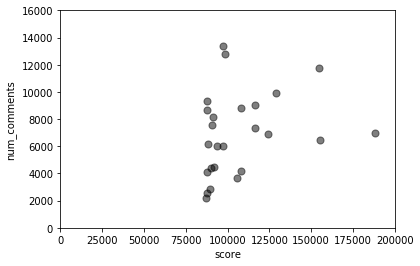

In [134]:
ax = top25_df.plot.scatter(x='score',y='num_comments',s=50,c='k',alpha=.5)
ax.set_xlim((0,200000))
ax.set_ylim((0,16000))

### Comments

This is a simple Reddit submission: [What is a dataset that you can't believe is available to the public?](https://www.reddit.com/r/datasets/comments/akb4mr/what_is_a_dataset_that_you_cant_believe_is/). We can inspect the comments in this simple submission.

[Documentation for Comment model in PRAW](https://praw.readthedocs.io/en/latest/code_overview/models/comment.html).

In [176]:
cant_believe = r.submission(id='akb4mr')

print("This submission was made on {0}.".format(datetime.utcfromtimestamp(cant_believe.created_utc)))
print("There are {0:,} comments.".format(cant_believe.num_comments))

This submission was made on 2019-01-27 10:59:04.
There are 33 comments.


We can inspect these comments, working from the [Comment Extraction and Parsing](https://praw.readthedocs.io/en/latest/tutorials/comments.html) tutorial in PRAW.

In [177]:
cant_believe.comments.replace_more(limit=None)

for comment in cant_believe.comments.list():
    print(comment.body)

State voter files. You can see whether every single registered voter voted in a given election. There’s actually a political science  [paper](https://scholar.google.com/scholar?hl=en&as_sdt=0%2C43&q=gerber+turnout+pressure&btnG=#d=gs_qabs&u=%23p%3D0F49X22wGIcJ) where the researchers threatened to send letters to all your neighbors with information about which people in the neighborhood had voted to see if it would increase turnout. It did. 
First and last name of every US person who has renounced their citizenship each quarter: [https://www.federalregister.gov/quarterly-publication-of-individuals-who-have-chosen-to-expatriate](https://www.federalregister.gov/quarterly-publication-of-individuals-who-have-chosen-to-expatriate)
The SEC published "Apache log files that record and store user access statistics for the SEC.gov website" for 2003 through 2017: https://www.sec.gov/dera/data/edgar-log-file-data-set.html
[Enron email dataset](https://www.cs.cmu.edu/~./enron/) 
ICIJ Offshore Leaks 

Each comment has a lot of metadata we can preserve.

In [201]:
cant_believe_comment_metadata = []

for comment in cant_believe.comments.list():
    if not comment.collapsed: # Skip collapsed/deleted comments
        d = {}
        d['id'] = comment.id
        d['parent_id'] = comment.parent_id
        d['body'] = comment.body
        d['depth'] = comment.depth
        d['edited'] = comment.edited
        d['score'] = comment.score
        d['date'] = datetime.utcfromtimestamp(comment.created_utc)
        d['submission_id'] = comment.submission.id
        d['submission_title'] = comment.submission.title
        d['subreddit'] = comment.subreddit.display_name
        d['author'] = comment.author.name
        cant_believe_comment_metadata.append(d)

Convert to a DataFrame.

In [221]:
cant_believe_df = pd.DataFrame(cant_believe_comment_metadata)

# How long is the comment
cant_believe_df['comment_length'] = cant_believe_df['body'].str.len()

cant_believe_df.head()

,author,body,date,depth,edited,id,parent_id,score,submission_id,submission_title,subreddit,comment_length
0,jmarther,State voter files. You can see whether every s...,2019-01-27 14:03:19,0,False,ef3kluj,t3_akb4mr,63,akb4mr,What is a dataset that you can’t believe is av...,datasets,444
1,hamiltonkg,First and last name of every US person who has...,2019-01-27 11:52:02,0,False,ef3cp0s,t3_akb4mr,80,akb4mr,What is a dataset that you can’t believe is av...,datasets,289
2,brianckeegan,"The SEC published ""Apache log files that recor...",2019-01-27 21:35:25,0,1.54863e+09,ef4iy3r,t3_akb4mr,14,akb4mr,What is a dataset that you can’t believe is av...,datasets,187
3,mouse_Brains,[Enron email dataset](https://www.cs.cmu.edu/~...,2019-01-27 20:42:16,0,False,ef4fe4q,t3_akb4mr,16,akb4mr,What is a dataset that you can’t believe is av...,datasets,56
4,emican,ICIJ Offshore Leaks Database\n\n[https://offsh...,2019-01-28 00:58:37,0,1.54864e+09,ef4ykjj,t3_akb4mr,5,akb4mr,What is a dataset that you can’t believe is av...,datasets,349


Do comments deeper in this comment tree have lower scores?

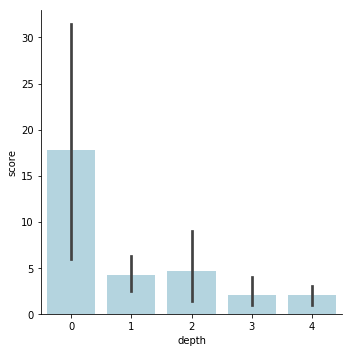

In [220]:
sb.catplot(x='depth',y='score',data=cant_believe_df,kind='bar',color='lightblue')

Do comments deeper in this comment tree have shorter lengths?

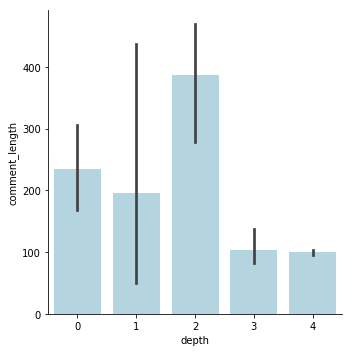

In [222]:
sb.catplot(x='depth',y='comment_length',data=cant_believe_df,kind='bar',color='lightblue')

### Redditors

A Redditor is a user and we can get meta-data about the account as well as the history of the user's comments and submissions from the API.

[Documentation for the Redditor model in PRAW](https://praw.readthedocs.io/en/latest/code_overview/models/redditor.html).

How much link and comment karma does this user have?

In [237]:
spez = r.redditor('spez')
print("Link karma: {0:,}".format(spez.link_karma))
print("Comment karma: {0:,}".format(spez.comment_karma))

Link karma: 108,760
Comment karma: 665,490


Interestingly, Reddit flags the users who are employees of Reddit as well as if accounts have verified email addresses.

In [235]:
spez.is_employee

True

In [239]:
spez.has_verified_email

True

We can also get the time this user's account was created.

In [236]:
datetime.utcfromtimestamp(spez.created_utc)

datetime.datetime(2005, 6, 6, 4, 0)

We can also get information about individual redditors' submissions and comment histories. Here we will use u/spez (the CEO of Reddit), get his top-voted submissions, and loop through them to get the data for each submission.

In [138]:
spez_submissions = []

for submission in r.redditor('spez').submissions.top('all',limit=25):
    d = {}
    d['id'] = submission.id
    d['title'] = submission.title
    d['num_comments'] = submission.num_comments
    d['score'] = submission.score
    d['upvote_ratio'] = submission.upvote_ratio
    d['date'] = datetime.utcfromtimestamp(submission.created_utc)
    d['domain'] = submission.domain
    d['gilded'] = submission.gilded
    d['num_crossposts'] = submission.num_crossposts
    d['nsfw'] = submission.over_18
    d['author'] = submission.author.name
    spez_submissions.append(d)

Again we can turn this list of dictionaries into a DataFrame to do substantive data analysis.

In [140]:
pd.DataFrame(spez_submissions).head()

,author,date,domain,gilded,id,nsfw,num_comments,num_crossposts,score,title,upvote_ratio
0,spez,2017-12-14 17:10:15,self.announcements,7,7jsyqt,False,14866,17,194088,"The FCC’s vote was predictably frustrating, bu...",0.86
1,spez,2017-11-27 18:03:30,self.blog,4,7fx1x4,False,7886,16,92810,An update on the fight for the free and open i...,0.81
2,spez,2016-11-30 19:04:49,self.announcements,32,5frg1n,False,35841,0,50315,TIFU by editing some comments and creating an ...,0.61
3,spez,2015-07-11 17:02:59,self.IAmA,2,3cxedn,False,12864,0,41367,"I am Steve Huffman, the new CEO of reddit. AMA.",0.83
4,spez,2016-10-26 21:00:53,self.announcements,3,59k22p,False,12402,0,32210,"Hey, it’s Reddit’s totally politically neutral...",0.64


We can also get all the comments made by an editor.

In [170]:
spez_comments = []

for comment in r.redditor('spez').comments.top('all',limit=25):
    d = {}
    d['id'] = comment.id
    d['body'] = comment.body
    d['depth'] = comment.depth
    d['edited'] = comment.edited
    d['score'] = comment.score
    d['date'] = datetime.utcfromtimestamp(comment.created_utc)
    d['submission_id'] = comment.submission.id
    d['submission_title'] = comment.submission.title
    d['subreddit'] = comment.subreddit.display_name
    d['author'] = comment.author.name
    spez_comments.append(d)

In [171]:
pd.DataFrame(spez_comments).head()

,author,body,date,edited,id,score,submission_date,submission_id,submission_title,subreddit
0,spez,Reddit search might work by then.,2016-10-26 21:07:22,False,d992fwq,22199,2016-10-26 21:00:53,59k22p,"Hey, it’s Reddit’s totally politically neutral...",announcements
1,spez,No. We don’t negotiate with terrorists.,2017-12-14 19:33:42,False,dr95e2i,20228,2017-12-14 17:10:15,7jsyqt,"The FCC’s vote was predictably frustrating, bu...",announcements
2,spez,good bot,2017-12-14 17:11:41,False,dr8whnr,17498,2017-12-14 17:10:15,7jsyqt,"The FCC’s vote was predictably frustrating, bu...",announcements
3,spez,On Reddit.,2016-10-26 21:14:49,False,d992soe,13844,2016-10-26 21:00:53,59k22p,"Hey, it’s Reddit’s totally politically neutral...",announcements
4,spez,"> However, why not allow a small 5 minute wind...",2016-11-30 19:40:47,False,damgw92,12698,2016-11-30 19:04:49,5frg1n,TIFU by editing some comments and creating an ...,announcements


This user's top comments are mostly focused in the /r/announcements subreddit.

In [240]:
pd.DataFrame(spez_comments)['subreddit'].value_counts()

announcements    21
IAmA              2
blog              1
RoastMe           1
Name: subreddit, dtype: int64